<a href="https://colab.research.google.com/github/mahesh-ml/MLBasics/blob/main/recursive_feature_eliminate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

In [3]:
data = pd.read_csv('/content/dataset_1.csv')
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,...,var_262,var_263,var_264,var_265,var_266,var_267,var_268,var_269,var_270,var_271,var_272,var_273,var_274,var_275,var_276,var_277,var_278,var_279,var_280,var_281,var_282,var_283,var_284,var_285,var_286,var_287,var_288,var_289,var_290,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.00,0,0,0.0000,0.0,0,0,0,0.0,0.0,0,1.98,0.0000,3,0.0,0,0,0.0000,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0.00,0,0.0000,0,0,0.0,0.00,0,0,0,0.0,0.00,0,0.00,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0,3,0.0,0.0,0.00,0,0,2.7300,0.0,0,0,0,0.0,0.0,0,1.92,0.0000,0,0.0,0,0,2.9100,0,0,0,0.0,0.0,...,1,0,0.0,0.0,0.00,0,0.0000,0,0,0.0,0.00,0,0,0,0.0,0.00,0,0.00,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,0.0,0.0,0.0,0,3,0.0,0.0,0.00,0,0,19.8990,0.0,0,0,0,0.0,0.0,0,1.94,69867.6741,3,0.0,0,0,71397.5526,0,0,3,0.0,0.0,...,2,0,0.0,0.0,0.00,0,0.0000,0,0,0.0,0.00,0,0,0,0.0,0.00,0,0.00,0.0,0,0,0.0,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,988.47,0,0,0.0000,0.0,0,0,0,0.0,0.0,0,7.44,0.0000,6,0.0,0,0,19.0164,0,0,0,0.0,0.0,...,4,0,0.0,0.0,450.42,0,90.8868,0,0,0.0,36.27,0,0,0,0.0,8.55,0,26.73,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,0.0,0.0,0.0,0,3,0.0,0.0,0.00,0,0,5981.1741,0.0,0,0,0,0.0,0.0,0,1.94,0.0000,3,0.0,0,0,6285.6000,0,0,0,0.0,0.0,...,2,0,0.0,0.0,0.00,0,0.0000,0,0,0.0,0.00,0,0,0,0.0,0.00,0,0.00,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0000,0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

In [9]:
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 158), (15000, 158))

In [10]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


6

In [11]:
model_full = GradientBoostingClassifier(n_estimators=10,max_depth=4,random_state=10)
model_full.fit(X_train,y_train )
y_predict_test= model_full.predict_proba(X_test)[:,1]
roc_full = roc_auc_score(y_test, y_predict_test)
print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.827570


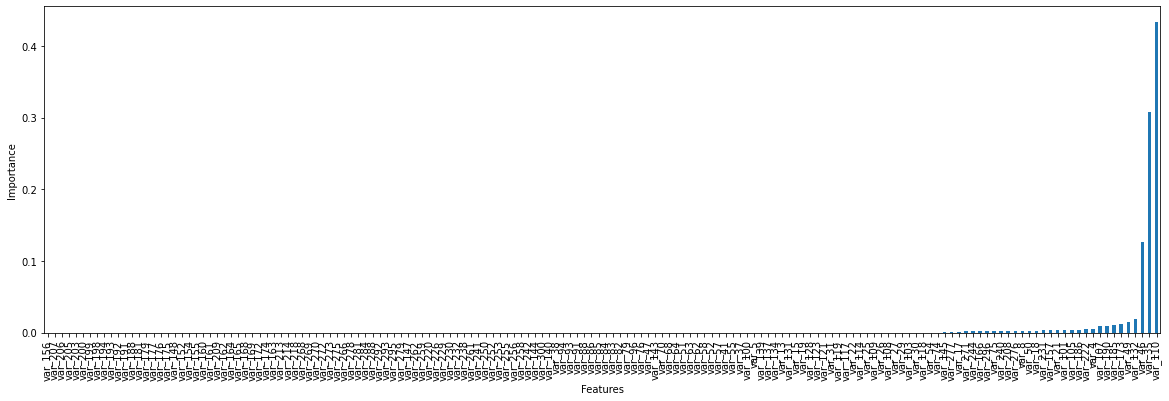

In [12]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [14]:
features = list(features.index)
features
#remove feature recursively
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an model at each round.

# once we build the model, we calculate the new roc-auc

# if the new roc-auc is smaller than the original one
# (with all the features), then the feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know where the loop is
count = 1

# now we loop over all the features, in order of importance:
# remember that features is this list are ordered
# by importance
for feature in features:
    
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with all variables, minus the feature to be evaluated
    # and also minus all features that were deemed to be removed
    
    # note that features_to_remove will be empty in the first rounds
    # but will have features as the loop proceeds
    model_int.fit(X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction using the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with all the features
    print('Full dataset ROC AUC={}'.format((roc_full)))

    # determine the drop in the roc-auc
    diff_roc = roc_full - roc_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        roc_full = roc_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))


doing recursive feature elimination

testing feature:  var_156 1  out of  158
New Test ROC AUC=0.8275178808096737
Full dataset ROC AUC=0.8275697641230844
Drop in ROC AUC=5.18833134106611e-05
remove:  var_156

testing feature:  var_207 2  out of  158
New Test ROC AUC=0.8275087249308363
Full dataset ROC AUC=0.8275178808096737
Drop in ROC AUC=9.155878837430187e-06
remove:  var_207

testing feature:  var_206 3  out of  158
New Test ROC AUC=0.8273887942216233
Full dataset ROC AUC=0.8275087249308363
Drop in ROC AUC=0.00011993070921301197
remove:  var_206

testing feature:  var_205 4  out of  158
New Test ROC AUC=0.8275114377838253
Full dataset ROC AUC=0.8273887942216233
Drop in ROC AUC=-0.00012264356220204053
remove:  var_205

testing feature:  var_203 5  out of  158
New Test ROC AUC=0.8274971953056339
Full dataset ROC AUC=0.8275114377838253
Drop in ROC AUC=1.4242478191373031e-05
remove:  var_203

testing feature:  var_200 6  out of  158
New Test ROC AUC=0.8274517550180717
Full dataset ROC A

In [15]:
features_to_keep

['var_166',
 'var_75',
 'var_157',
 'var_101',
 'var_105',
 'var_107',
 'var_190',
 'var_185',
 'var_173',
 'var_132',
 'var_46',
 'var_35',
 'var_110']

In [16]:
# finally let's test the performance of the model 
# built on the selected features

# build initial model
model_final = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict(X_test[features_to_keep])

# calculate roc-auc
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.071717
